In [4]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from pathlib import Path
from functools import reduce

In [5]:
path_folder='../../DATAFLOW_2026_UET.EPOCH_0_AUTOSCALING_ANALYSIS/features'
def read_pa(path_folder):
    files= list(Path(path_folder).glob('*.parquet'))
    for f in files:
        df=pd.read_parquet(f)
        print (df.head(2))
    return
read_pa(path_folder)

   index  bytes
0      0  6.245
1      1  3.985
   index visitor_type  is_commercial  is_unknown  visitor_type_freq  \
0      0      unknown              0           1           0.253658   
1      1      network              0           0           0.086453   

  visitor_country  country_freq  is_top_country  
0   other_country      0.855195               0  
1   other_country      0.855195               0  
   index  response response_class
0      0       200     successful
1      1       200     successful
   index           timestamp  hour  day  weekday  month  is_weekend
0      0 1995-07-01 00:00:01     0    1        5      7           1
1      1 1995-07-01 00:00:06     0    1        5      7           1
   index reqmethod         reqdirectory reqresourcetype  reqpathdepth  \
0      0       GET     /history/apollo/       Directory             3   
1      1       GET  /shuttle/countdown/       Directory             3   

   is_dynamic  requrllength  
0           0            16  
1 

In [6]:
path_folder='../../DATAFLOW_2026_UET.EPOCH_0_AUTOSCALING_ANALYSIS/features'
def join_columns(path_folder,mode: str="merge",key: str="index",drop_index_col: bool = False,how: str="outer"):
    files= list(Path(path_folder).glob('*.parquet'))

    dfs =[]
    for f in files:
        df=pd.read_parquet(f)
        if mode == "concat":
            # Nếu cột "index" chỉ là cột thừa do save file thì bỏ
            if drop_index_col and key in df.columns:
                df = df.drop(columns=[key])
            dfs.append(df)

        elif mode == "merge":
            if key not in df.columns:
                raise ValueError(f"File {f.name} không có cột key '{key}'")

            dfs.append(df)

        else:
            raise ValueError("mode chỉ nhận 'concat' hoặc 'merge'")

    if mode == "concat":
        out = pd.concat(dfs, ignore_index=True)
    else:
        out = reduce(lambda a, b: pd.merge(a, b, on=key, how=how), dfs)
    return out
df=join_columns(path_folder)


In [7]:
df.head(5)

,index,bytes,visitor_type,is_commercial,is_unknown,visitor_type_freq,visitor_country,country_freq,is_top_country,response,...,day,weekday,month,is_weekend,reqmethod,reqdirectory,reqresourcetype,reqpathdepth,is_dynamic,requrllength
0,0,6.245,unknown,0,1,0.253658,other_country,0.855195,0,200,...,1,5,7,1,GET,/history/apollo/,Directory,3,0,16
1,1,3.985,network,0,0,0.086453,other_country,0.855195,0,200,...,1,5,7,1,GET,/shuttle/countdown/,Directory,3,0,19
2,2,4.085,unknown,0,1,0.253658,other_country,0.855195,0,200,...,1,5,7,1,GET,/shuttle/missions/sts-73/,Page,4,0,44
3,3,0.000,commercial,1,0,0.299574,other_country,0.855195,0,304,...,1,5,7,1,GET,/shuttle/countdown/,Page,3,0,31
4,4,4.179,unknown,0,1,0.253658,other_country,0.855195,0,200,...,1,5,7,1,GET,/shuttle/missions/sts-73/,Image,4,0,47


/tmp/ipykernel_6723/894767935.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_6723/894767935.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


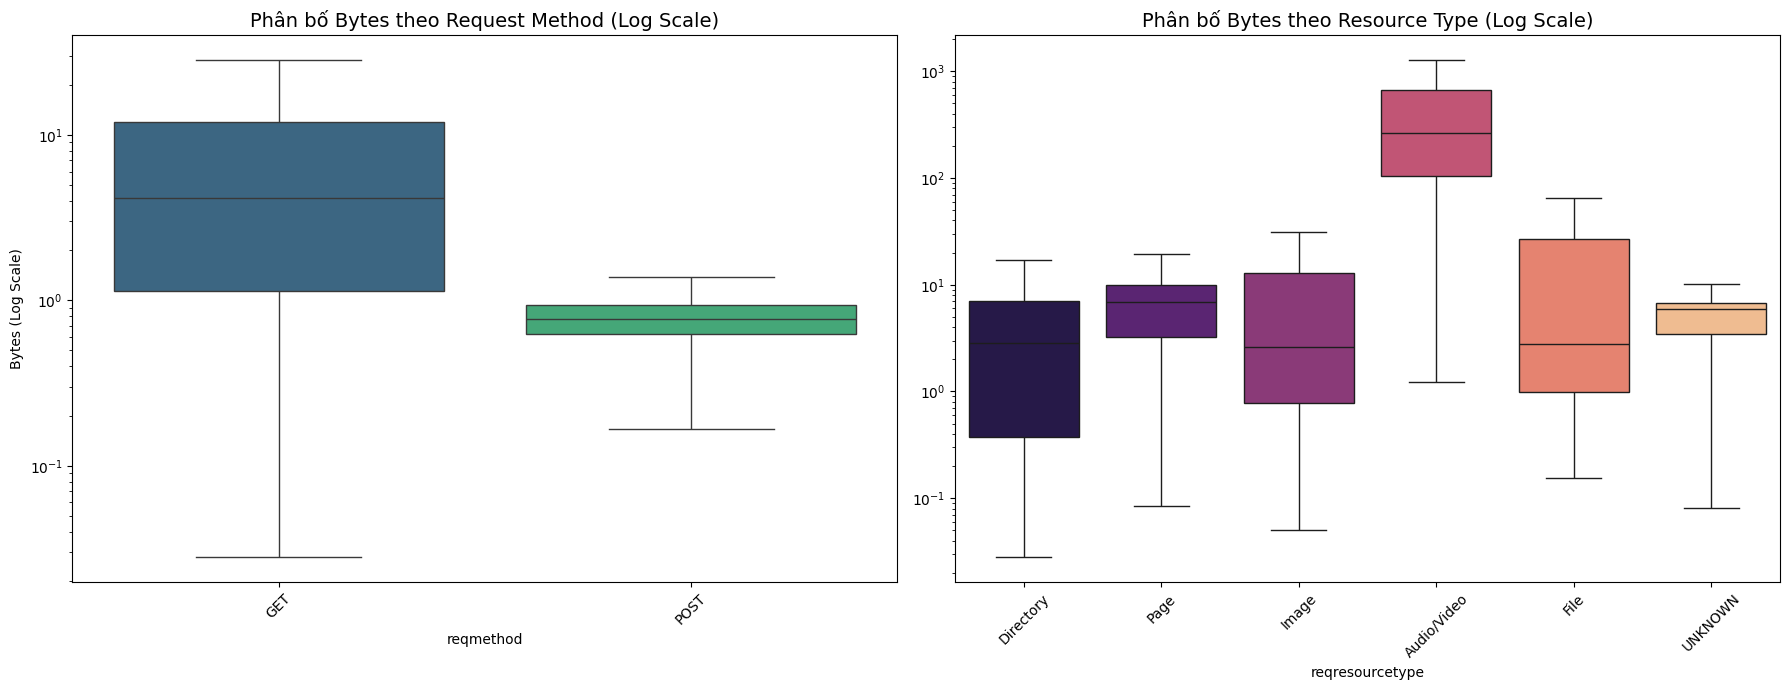

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def plot_categorical_vs_bytes(df):
    """
    Vẽ 2 biểu đồ Boxplot:
    1. Request Method vs Bytes
    2. Resource Type vs Bytes
    """
    # 1. Lọc bỏ dữ liệu rác và lấy Bytes > 0 để vẽ Log Scale cho đẹp
    # (Vì Bytes = 0 không vẽ được trên thang Log)
    plot_data = df[df['bytes'] > 0].copy()
    
    # Thiết lập khung hình: 1 dòng, 2 cột
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))

    # --- BIỂU ĐỒ 1: METHOD VS BYTES ---
    sns.boxplot(
        data=plot_data,
        x='reqmethod', 
        y='bytes',
        ax=axes[0],
        palette='viridis',
        showfliers=False # Ẩn bớt điểm ngoại lai (outliers) để nhìn hộp cho rõ
    )
    axes[0].set_title('Phân bố Bytes theo Request Method (Log Scale)', fontsize=14)
    axes[0].set_yscale('log') # QUAN TRỌNG: Dùng thang đo Logarit vì bytes chênh lệch rất lớn
    axes[0].set_ylabel('Bytes (Log Scale)')
    axes[0].tick_params(axis='x', rotation=45) # Xoay chữ cho dễ đọc

    # --- BIỂU ĐỒ 2: RESOURCE TYPE VS BYTES ---
    sns.boxplot(
        data=plot_data,
        x='reqresourcetype', 
        y='bytes',
        ax=axes[1],
        palette='magma',
        showfliers=False
    )
    axes[1].set_title('Phân bố Bytes theo Resource Type (Log Scale)', fontsize=14)
    axes[1].set_yscale('log') # Dùng thang đo Logarit
    axes[1].set_ylabel('') # Bỏ nhãn trục Y bên phải cho đỡ rối
    axes[1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

# --- CÁCH SỬ DỤNG ---
plot_categorical_vs_bytes(df)

In [9]:
def onehot_feature_categorical(df):
    df=df.copy()

    df['is_heavy'] = df['reqresourcetype'].isin(['Audio/Video', 'File']).astype('int8')
    df['is_image'] = (df['reqresourcetype'] == 'Image').astype('int8')
    df['is_get'] = (df['reqmethod'] == 'GET').astype('int8')
    df['is_post'] = (df['reqmethod'] == 'POST').astype('int8')

    return df
df=onehot_feature_categorical(df)
df.head(5)

,index,bytes,visitor_type,is_commercial,is_unknown,visitor_type_freq,visitor_country,country_freq,is_top_country,response,...,reqmethod,reqdirectory,reqresourcetype,reqpathdepth,is_dynamic,requrllength,is_heavy,is_image,is_get,is_post
0,0,6.245,unknown,0,1,0.253658,other_country,0.855195,0,200,...,GET,/history/apollo/,Directory,3,0,16,0,0,1,0
1,1,3.985,network,0,0,0.086453,other_country,0.855195,0,200,...,GET,/shuttle/countdown/,Directory,3,0,19,0,0,1,0
2,2,4.085,unknown,0,1,0.253658,other_country,0.855195,0,200,...,GET,/shuttle/missions/sts-73/,Page,4,0,44,0,0,1,0
3,3,0.000,commercial,1,0,0.299574,other_country,0.855195,0,304,...,GET,/shuttle/countdown/,Page,3,0,31,0,0,1,0
4,4,4.179,unknown,0,1,0.253658,other_country,0.855195,0,200,...,GET,/shuttle/missions/sts-73/,Image,4,0,47,0,1,1,0


In [10]:
df.isnull().sum()

index                    0
bytes                28490
visitor_type             0
is_commercial            0
is_unknown               0
visitor_type_freq        0
visitor_country          0
country_freq             0
is_top_country           0
response                 0
response_class           0
timestamp                0
hour                     0
day                      0
weekday                  0
month                    0
is_weekend               0
reqmethod                0
reqdirectory             0
reqresourcetype          0
reqpathdepth             0
is_dynamic               0
requrllength             0
is_heavy                 0
is_image                 0
is_get                   0
is_post                  0
dtype: int64

In [11]:
df[df['bytes'].isnull()]['response'].value_counts()

response
404    17028
302    11174
200      136
403      111
501       31
400       10
Name: count, dtype: int64

In [12]:
def flag_missing_bytes(df):
    df["bytes_missing"] = df["bytes"].isna().astype("int8")
    return df
df=flag_missing_bytes(df)
df.head(5)


,index,bytes,visitor_type,is_commercial,is_unknown,visitor_type_freq,visitor_country,country_freq,is_top_country,response,...,reqdirectory,reqresourcetype,reqpathdepth,is_dynamic,requrllength,is_heavy,is_image,is_get,is_post,bytes_missing
0,0,6.245,unknown,0,1,0.253658,other_country,0.855195,0,200,...,/history/apollo/,Directory,3,0,16,0,0,1,0,0
1,1,3.985,network,0,0,0.086453,other_country,0.855195,0,200,...,/shuttle/countdown/,Directory,3,0,19,0,0,1,0,0
2,2,4.085,unknown,0,1,0.253658,other_country,0.855195,0,200,...,/shuttle/missions/sts-73/,Page,4,0,44,0,0,1,0,0
3,3,0.000,commercial,1,0,0.299574,other_country,0.855195,0,304,...,/shuttle/countdown/,Page,3,0,31,0,0,1,0,0
4,4,4.179,unknown,0,1,0.253658,other_country,0.855195,0,200,...,/shuttle/missions/sts-73/,Image,4,0,47,0,1,1,0,0


Số lượng điểm dữ liệu: 2906440


/tmp/ipykernel_6723/1582508339.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


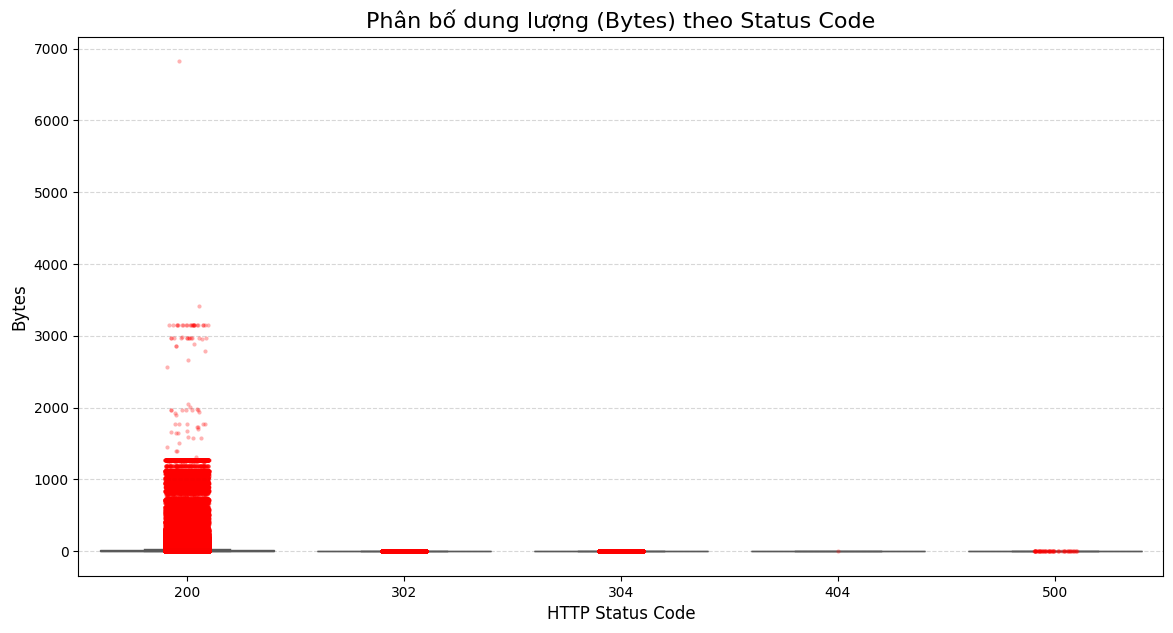

In [13]:

def plot_status_vs_bytes(df, col_status='response', col_bytes='bytes'):
    """
    Vẽ biểu đồ phân bố Bytes theo từng loại Status Code.
    Dùng Boxplot kết hợp Strip plot để nhìn rõ nhất.
    """
    
    # 1. Làm sạch dữ liệu
    data_clean = df[[col_status, col_bytes]].dropna().copy()
    
    # Chuyển status sang dạng String (để biểu đồ hiểu đây là phân loại, không phải số)
    data_clean[col_status] = data_clean[col_status].astype(str)

    # Sắp xếp thứ tự status cho đẹp (200, 302, 404, 500...)
    sorted_status = sorted(data_clean[col_status].unique())

    print(f"Số lượng điểm dữ liệu: {len(data_clean)}")

    # 2. Thiết lập khung hình
    plt.figure(figsize=(14, 7))

    # 3. Vẽ biểu đồ
    # Cách A: Box Plot - Để xem phân phối (Min, Max, Trung vị) - Rất chuyên nghiệp
    sns.boxplot(
        data=data_clean,
        x=col_status,
        y=col_bytes,
        order=sorted_status,
        palette="Set2",
        showfliers=False # Tạm ẩn các điểm nhiễu (outliers) quá xa để nhìn cho gọn khung hình
    )

    # Cách B: Strip Plot - Để rải các điểm dữ liệu lên trên (giống Scatter)
    # Giúp nhìn thấy mật độ: Status nào có nhiều request nhất?
    sns.stripplot(
        data=data_clean,
        x=col_status,
        y=col_bytes,
        order=sorted_status,
        color='red',
        alpha=0.3, # Độ mờ
        size=3,    # Kích thước chấm nhỏ
        jitter=True # Rung lắc nhẹ để các điểm không đè lên nhau
    )

    # 4. Trang trí
    plt.title(f'Phân bố dung lượng (Bytes) theo Status Code', fontsize=16)
    plt.xlabel('HTTP Status Code', fontsize=12)
    plt.ylabel('Bytes', fontsize=12)
    plt.grid(True, axis='y', linestyle='--', alpha=0.5)
    
    # Mẹo: Nếu chênh lệch bytes quá lớn (cái 100 bytes, cái 1GB), hãy bật log scale
    # plt.yscale('log') 

    plt.show()

# --- CÁCH DÙNG ---
# plot_status_vs_bytes(df, col_status='status', col_bytes='y_bytes_imp')
plot_status_vs_bytes(df)

In [14]:
def add_bytes_imputed(df):
    """fill NaN"""
    df = df.copy()
    df["bytes"] = pd.to_numeric(df["bytes"], errors="coerce")
    df["bytes_imputed"] = df["bytes"]

    # median bytes theo từng status code
    med = df.groupby("response")["bytes"].median()

    # 3xx 
    m3 = (df["response_class"] == "redirection") & df["bytes_imputed"].isna()
    df.loc[m3, "bytes_imputed"] = 0

    # 2xx -> fill median theo response
    m2 = df["response"].between(200, 299) & df["bytes_imputed"].isna()
    df.loc[m2, "bytes_imputed"] = df.loc[m2, "response"].map(med).fillna(0)

    # 4xx -> fill median theo response
    m4 = df["response"].between(400, 499) & df["bytes_imputed"].isna()
    df.loc[m4, "bytes_imputed"] = df.loc[m4, "response"].map(med).fillna(0)

    # 5xx 
    m5 = df["response"].between(500,599) & df["bytes_imputed"].isna()
    df.loc[m5, "bytes_imputed"] = df.loc[m5, "response"].map(med).fillna(0)

    return df

df = add_bytes_imputed(df)


In [15]:
df.columns

Index(['index', 'bytes', 'visitor_type', 'is_commercial', 'is_unknown',
       'visitor_type_freq', 'visitor_country', 'country_freq',
       'is_top_country', 'response', 'response_class', 'timestamp', 'hour',
       'day', 'weekday', 'month', 'is_weekend', 'reqmethod', 'reqdirectory',
       'reqresourcetype', 'reqpathdepth', 'is_dynamic', 'requrllength',
       'is_heavy', 'is_image', 'is_get', 'is_post', 'bytes_missing',
       'bytes_imputed'],
      dtype='str')

In [16]:
df['bytes_missing'].value_counts()

bytes_missing
0    2906440
1      28490
Name: count, dtype: int64

In [17]:
df['bytes_imputed'].isnull().sum()

np.int64(0)

/tmp/ipykernel_6723/1757310612.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='hour', y='bytes_imputed', ax=ax2, showfliers=False, palette='Blues')
/tmp/ipykernel_6723/1757310612.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='weekday', y='bytes_imputed', ax=ax3, showfliers=False, palette='Greens')


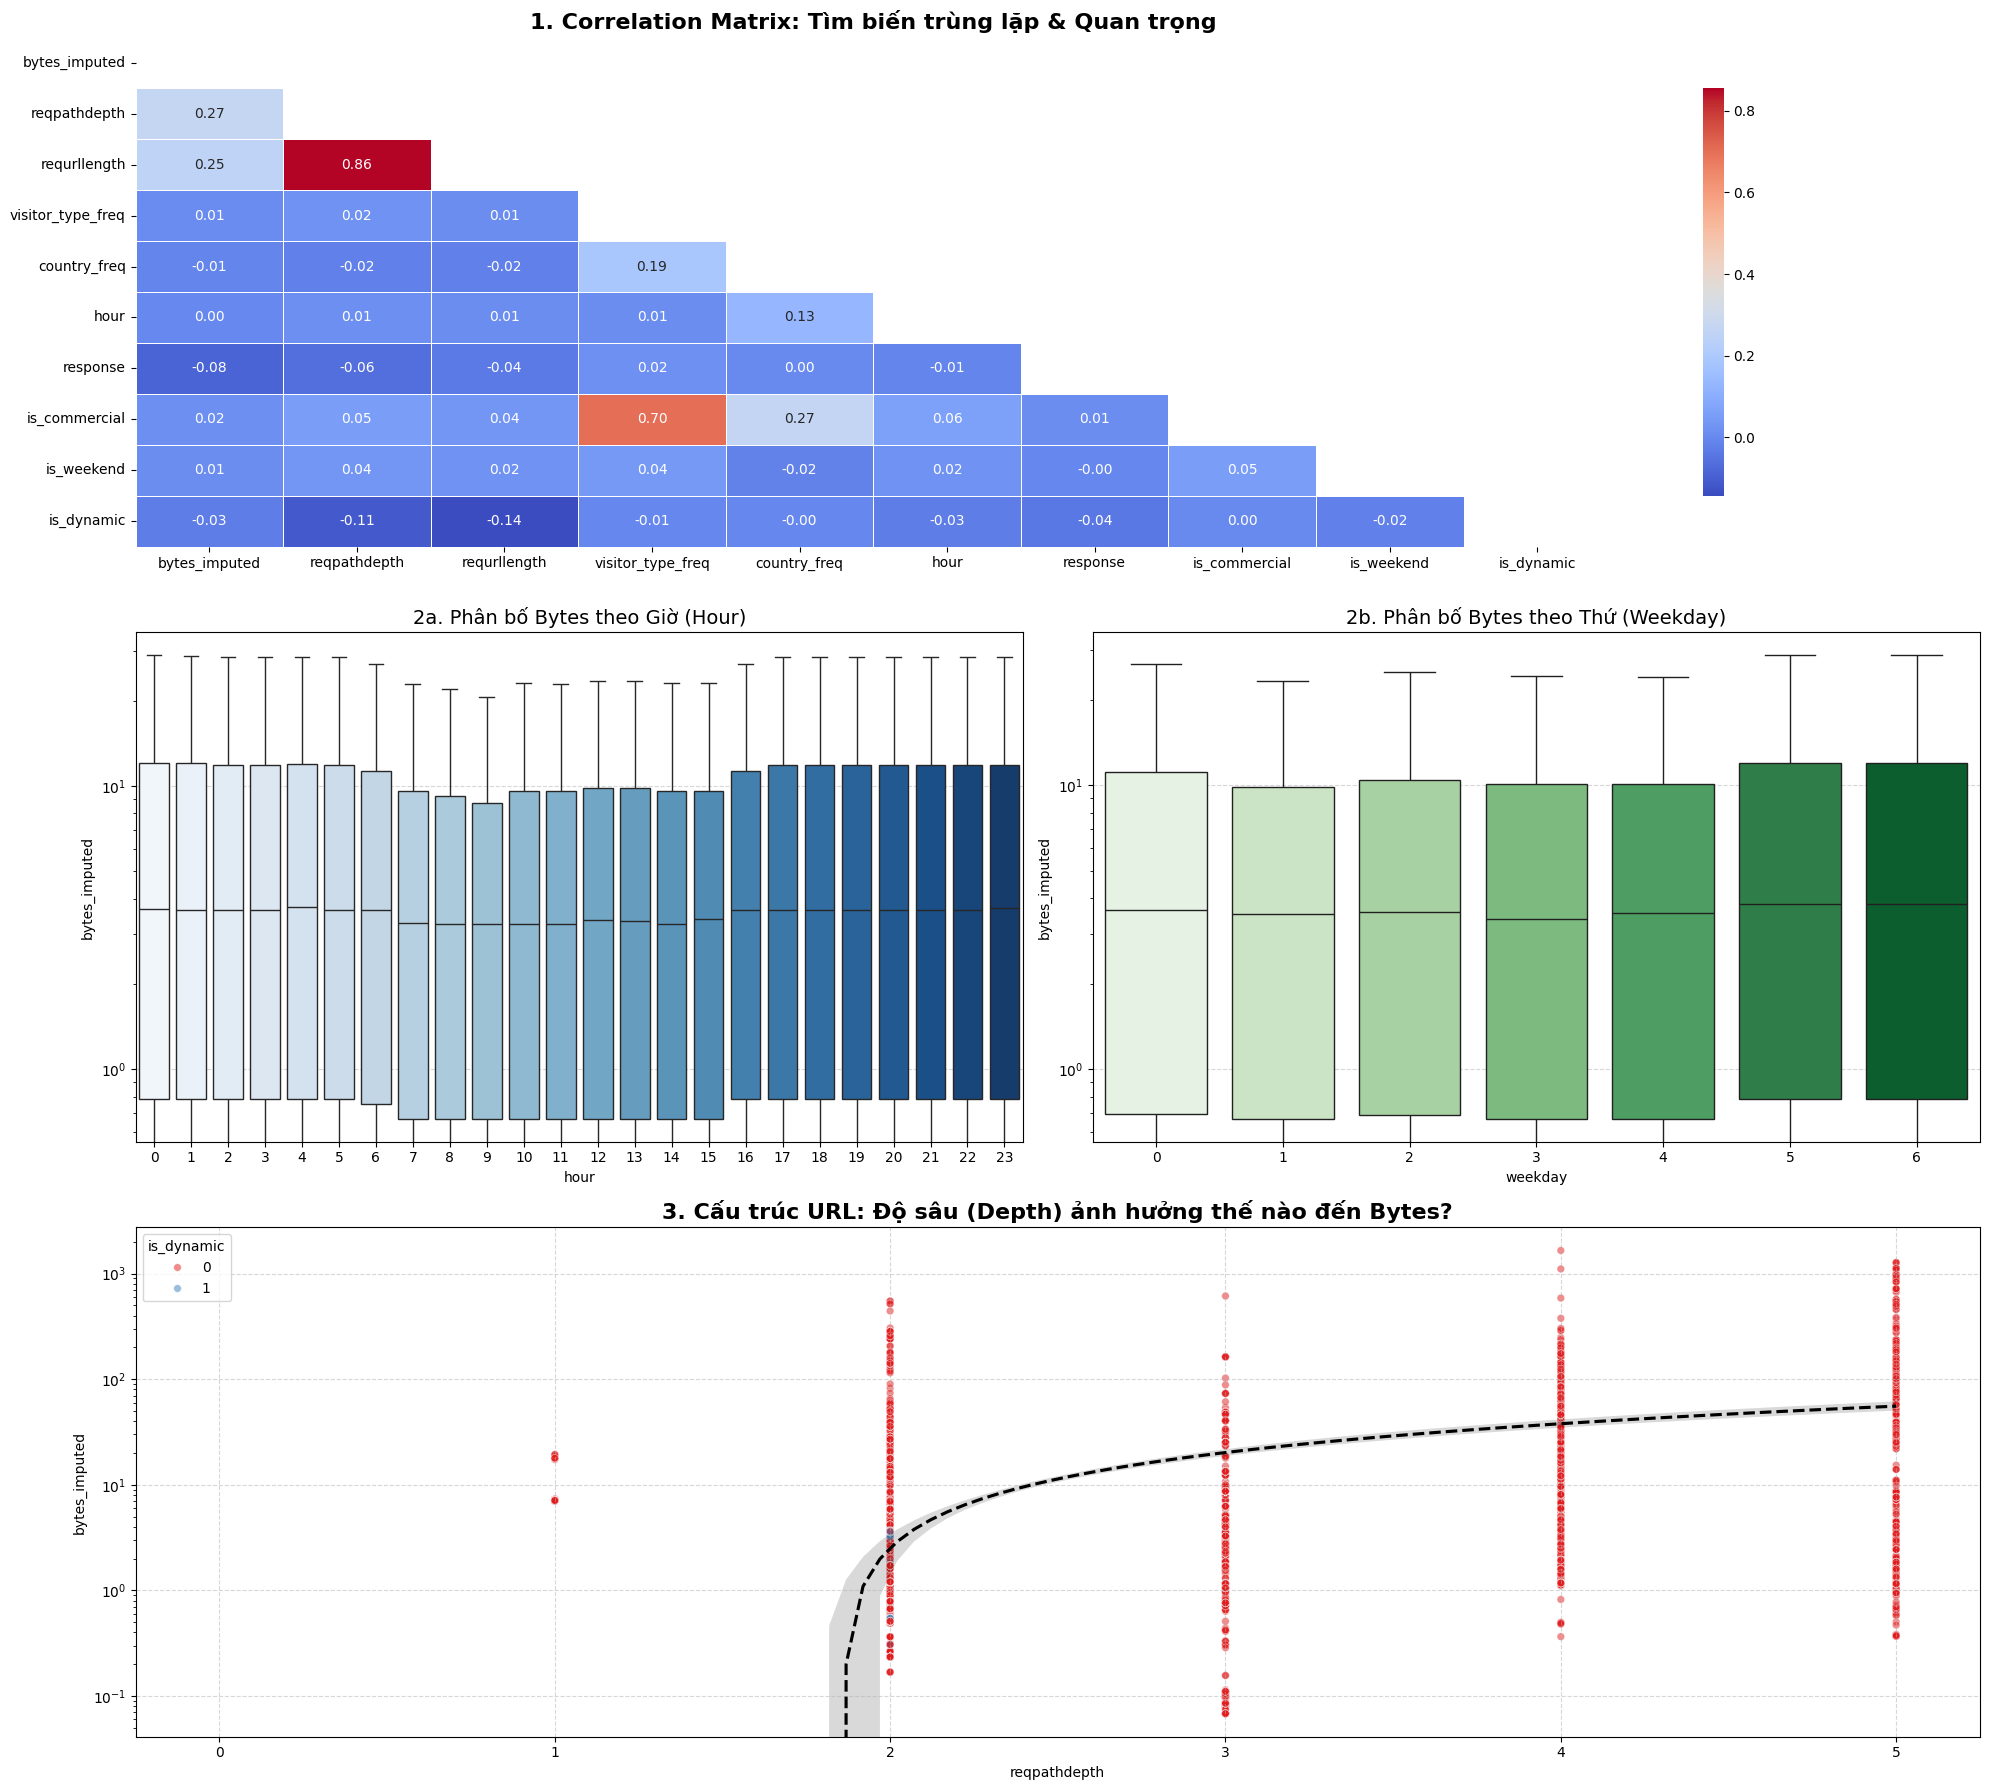

In [18]:


def analyze_feature_selection_dashboard(df):
    """
    Vẽ Dashboard 3-trong-1 để chọn Feature cho Model:
    1. Correlation Heatmap: Kiểm tra đa cộng tuyến.
    2. Seasonality Analysis: Kiểm tra chu kỳ thời gian (Giờ/Thứ).
    3. Structure Analysis: Kiểm tra độ sâu URL.
    """
    
    # --- BƯỚC 1: CHUẨN BỊ DỮ LIỆU ---
    # Danh sách các cột tiềm năng (Số hóa hết các cột boolean nếu cần)
    cols_numerical = [
        'bytes_imputed', 'reqpathdepth', 'requrllength', 
        'visitor_type_freq', 'country_freq', 'hour', 'response',
        'is_commercial', 'is_weekend', 'is_dynamic'
    ]
    
    # Lọc chỉ lấy các cột thực sự tồn tại trong df của bạn
    valid_cols = [c for c in cols_numerical if c in df.columns]
    
    # Thiết lập khung hình lớn (Dashboard)
    fig = plt.figure(figsize=(20, 18))
    # Tạo lưới: 3 hàng, 2 cột
    gs = fig.add_gridspec(3, 2)

    # --- BIỂU ĐỒ 1: CORRELATION HEATMAP (Hàng 0, chiếm cả 2 cột) ---
    ax1 = fig.add_subplot(gs[0, :])
    
    corr_matrix = df[valid_cols].corr()
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool)) # Che một nửa tam giác trên cho đỡ rối
    
    sns.heatmap(
        corr_matrix, 
        mask=mask,
        annot=True, 
        fmt=".2f", 
        cmap='coolwarm', 
        linewidths=0.5, 
        ax=ax1,
        cbar_kws={"shrink": 0.8}
    )
    ax1.set_title('1. Correlation Matrix: Tìm biến trùng lặp & Quan trọng', fontsize=16, fontweight='bold')

    # --- BIỂU ĐỒ 2: SEASONALITY (Hàng 1) ---
    # 2.1: Theo Giờ (Hàng 1, Cột 0)
    ax2 = fig.add_subplot(gs[1, 0])
    if 'hour' in df.columns:
        sns.boxplot(data=df, x='hour', y='bytes_imputed', ax=ax2, showfliers=False, palette='Blues')
        ax2.set_title('2a. Phân bố Bytes theo Giờ (Hour)', fontsize=14)
        ax2.set_yscale('log') # Log scale
        ax2.grid(True, axis='y', linestyle='--', alpha=0.5)

    # 2.2: Theo Thứ (Hàng 1, Cột 1)
    ax3 = fig.add_subplot(gs[1, 1])
    if 'weekday' in df.columns:
        sns.boxplot(data=df, x='weekday', y='bytes_imputed', ax=ax3, showfliers=False, palette='Greens')
        ax3.set_title('2b. Phân bố Bytes theo Thứ (Weekday)', fontsize=14)
        ax3.set_yscale('log')
        ax3.grid(True, axis='y', linestyle='--', alpha=0.5)

    # --- BIỂU ĐỒ 3: STRUCTURE ANALYSIS (Hàng 2, chiếm cả 2 cột) ---
    ax4 = fig.add_subplot(gs[2, :])
    if 'reqpathdepth' in df.columns:
        # Dùng scatterplot nhưng lấy sample (nếu dữ liệu quá lớn > 10k dòng thì lấy mẫu cho nhẹ)
        plot_data = df.sample(n=min(10000, len(df)), random_state=42)
        
        sns.scatterplot(
            data=plot_data, 
            x='reqpathdepth', 
            y='bytes_imputed', 
            hue='is_dynamic', # Tô màu thêm theo loại dynamic/static để nhìn rõ hơn
            alpha=0.5,
            s=30,
            ax=ax4,
            palette='Set1'
        )
        
        # Vẽ thêm đường xu hướng (Trendline)
        sns.regplot(
            data=plot_data, x='reqpathdepth', y='bytes_imputed', 
            scatter=False, ax=ax4, color='black', line_kws={'linestyle':'--'}
        )
        
        ax4.set_title('3. Cấu trúc URL: Độ sâu (Depth) ảnh hưởng thế nào đến Bytes?', fontsize=16, fontweight='bold')
        ax4.set_yscale('log')
        ax4.grid(True, linestyle='--', alpha=0.5)

    # --- HOÀN TẤT ---
    plt.tight_layout()
    plt.show()

# --- CHẠY HÀM ---
analyze_feature_selection_dashboard(df)

In [19]:
def _entropy(s: pd.Series) -> float:
    s = s.dropna()
    if len(s) == 0:
        return 0.0
    p = s.value_counts(normalize=True)
    return float(-(p * np.log2(p + 1e-12)).sum())

def _top_share(s: pd.Series,exclude=("other_country",)) -> float:
    s = s.dropna()
    s1=s[~s.isin(exclude)]
    if len(s) == 0:
        return 0.0
    if len(s1)==0:
        return 0.0
    return float(s1.value_counts().iloc[0] / len(s))

def make_train_table(df: pd.DataFrame, freq: str) -> pd.DataFrame:
    d = df.copy()
    d["timestamp"] = pd.to_datetime(d["timestamp"], errors="coerce")
    d = d.dropna(subset=["timestamp"]).sort_values("timestamp").set_index("timestamp")

    #đảm bảo numeric
    d["bytes"] = pd.to_numeric(d["bytes"], errors="coerce")
    d["bytes_imputed"] = pd.to_numeric(d["bytes_imputed"], errors="coerce")
    d["response"] = pd.to_numeric(d["response"], errors="coerce")

    r=d.resample(freq)

    out = pd.DataFrame(index=r.size().index)

    

    # bytes sum , request
    out["y_req"] = r["bytes"].size().astype("int64")
    out["y_bytes_imp"] = r["bytes_imputed"].sum()


    # Bytes quality 
    out["bytes_missing_rate"] = r["bytes_missing"].mean().fillna(0.0)
    out["bytes_all_missing"] = (out["bytes_missing_rate"] == 1.0).astype("int8")

    # Health / response mix 
    out["error_rate"] = (d["response"] >= 400).resample(freq).mean().fillna(0.0)
    out["server_error_rate"] = (d["response"] >= 500).resample(freq).mean().fillna(0.0)
    out["redirection_rate"] = ((d["response"] >= 300) & (d["response"] < 400)).resample(freq).mean().fillna(0.0)

    # Mix rates 
    out["dynamic_rate"] = r["is_dynamic"].mean().fillna(0.0)
    out["commercial_rate"] = r["is_commercial"].mean().fillna(0.0)
    out["unknown_rate"] = r["is_unknown"].mean().fillna(0.0)

    # URL/path 
    out["avg_path_depth"] = r["reqpathdepth"].mean()

    # Diversity / concentration 
    out["country_nunique"] = r["visitor_country"].nunique()
    out["dir_nunique"] = r["reqdirectory"].nunique()
    out["method_nunique"] = r["reqmethod"].nunique()

    out["top_country_share"] = r["visitor_country"].apply(_top_share).fillna(0.0)
    out["endpoint_entropy"] = r["reqdirectory"].apply(_entropy).fillna(0.0)
    # Content and behavior
    out["ratio_heavy"] = r["is_heavy"].mean().fillna(0.0)
    out["ratio_image"] = r["is_image"].mean().fillna(0.0)

    out["ratio_get"] = r["is_get"].mean().fillna(0.0)
    out["ratio_post"] = r["is_post"].mean().fillna(0.0)

    #  Time features 
    out = out.reset_index()
    out["hour"] = out["timestamp"].dt.hour
    out["weekday"] = out["timestamp"].dt.weekday
    out["is_weekend"] = (out["weekday"] >= 5).astype("int8")

    return out

def make_1m_5m_15m_train(df: pd.DataFrame):
    return {
        "1m": make_train_table(df, "1min"),
        "5m": make_train_table(df, "5min"),
        "15m": make_train_table(df, "15min"),
    }


In [20]:
tables = make_1m_5m_15m_train(df)
df_1m, df_5m, df_15m = tables["1m"], tables["5m"], tables["15m"]

In [21]:
display(df_1m)
display(df_5m)
display(df_15m)

,timestamp,y_req,y_bytes_imp,bytes_missing_rate,bytes_all_missing,error_rate,server_error_rate,redirection_rate,dynamic_rate,commercial_rate,...,method_nunique,top_country_share,endpoint_entropy,ratio_heavy,ratio_image,ratio_get,ratio_post,hour,weekday,is_weekend
0,1995-07-01 00:00:00,42,608.453,0.000000,0,0.000000,0.0,0.071429,0.000000,0.261905,...,1,0.047619,2.884403,0.023810,0.642857,1.0,0.0,0,5,1
1,1995-07-01 00:01:00,61,910.128,0.016393,0,0.016393,0.0,0.049180,0.016393,0.442623,...,1,0.065574,3.411756,0.065574,0.606557,1.0,0.0,0,5,1
2,1995-07-01 00:02:00,57,628.556,0.035088,0,0.000000,0.0,0.192982,0.000000,0.385965,...,1,0.035088,3.715645,0.052632,0.578947,1.0,0.0,0,5,1
3,1995-07-01 00:03:00,71,1747.389,0.014085,0,0.000000,0.0,0.169014,0.000000,0.704225,...,1,0.014085,3.601396,0.028169,0.577465,1.0,0.0,0,5,1
4,1995-07-01 00:04:00,70,1383.149,0.000000,0,0.000000,0.0,0.057143,0.000000,0.542857,...,1,0.014286,3.079143,0.042857,0.642857,1.0,0.0,0,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76315,1995-08-22 23:55:00,13,319.726,0.000000,0,0.000000,0.0,0.000000,0.000000,0.615385,...,1,0.230769,1.546594,0.000000,0.692308,1.0,0.0,23,1,0
76316,1995-08-22 23:56:00,21,436.101,0.000000,0,0.000000,0.0,0.000000,0.000000,0.285714,...,1,0.142857,2.944395,0.047619,0.571429,1.0,0.0,23,1,0
76317,1995-08-22 23:57:00,29,334.910,0.000000,0,0.000000,0.0,0.137931,0.000000,0.551724,...,1,0.068966,3.147304,0.000000,0.689655,1.0,0.0,23,1,0
76318,1995-08-22 23:58:00,29,283.098,0.448276,0,0.448276,0.0,0.000000,0.000000,0.620690,...,1,0.137931,2.891790,0.000000,0.586207,1.0,0.0,23,1,0


,timestamp,y_req,y_bytes_imp,bytes_missing_rate,bytes_all_missing,error_rate,server_error_rate,redirection_rate,dynamic_rate,commercial_rate,...,method_nunique,top_country_share,endpoint_entropy,ratio_heavy,ratio_image,ratio_get,ratio_post,hour,weekday,is_weekend
0,1995-07-01 00:00:00,301,5277.675,0.013289,0,0.003322,0.0,0.109635,0.003322,0.491694,...,1,0.026578,3.866601,0.043189,0.607973,1.000000,0.0,0,5,1
1,1995-07-01 00:05:00,267,5041.043,0.011236,0,0.000000,0.0,0.101124,0.007491,0.490637,...,1,0.044944,3.900038,0.026217,0.614232,1.000000,0.0,0,5,1
2,1995-07-01 00:10:00,242,6111.846,0.033058,0,0.016529,0.0,0.165289,0.008264,0.388430,...,1,0.061983,3.999979,0.053719,0.545455,1.000000,0.0,0,5,1
3,1995-07-01 00:15:00,282,4559.748,0.024823,0,0.014184,0.0,0.109929,0.017730,0.411348,...,2,0.049645,4.426225,0.042553,0.524823,0.996454,0.0,0,5,1
4,1995-07-01 00:20:00,319,7262.385,0.006270,0,0.000000,0.0,0.075235,0.003135,0.592476,...,1,0.028213,3.977305,0.047022,0.630094,1.000000,0.0,0,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15259,1995-08-22 23:35:00,127,2410.781,0.007874,0,0.000000,0.0,0.157480,0.015748,0.299213,...,1,0.228346,4.095580,0.055118,0.559055,1.000000,0.0,23,1,0
15260,1995-08-22 23:40:00,119,3383.983,0.008403,0,0.000000,0.0,0.067227,0.016807,0.268908,...,1,0.210084,3.575257,0.025210,0.638655,1.000000,0.0,23,1,0
15261,1995-08-22 23:45:00,128,1618.155,0.000000,0,0.000000,0.0,0.031250,0.031250,0.367188,...,1,0.101562,4.084003,0.039062,0.609375,1.000000,0.0,23,1,0
15262,1995-08-22 23:50:00,137,1169.948,0.014599,0,0.014599,0.0,0.043796,0.014599,0.540146,...,1,0.087591,3.945751,0.043796,0.598540,1.000000,0.0,23,1,0


,timestamp,y_req,y_bytes_imp,bytes_missing_rate,bytes_all_missing,error_rate,server_error_rate,redirection_rate,dynamic_rate,commercial_rate,...,method_nunique,top_country_share,endpoint_entropy,ratio_heavy,ratio_image,ratio_get,ratio_post,hour,weekday,is_weekend
0,1995-07-01 00:00:00,810,16430.564,0.018519,0,0.006173,0.0,0.123457,0.006173,0.460494,...,1,0.024691,4.102642,0.040741,0.591358,1.000000,0.000000,0,5,1
1,1995-07-01 00:15:00,945,18046.060,0.013757,0,0.005291,0.0,0.097354,0.007407,0.522751,...,2,0.017989,4.317121,0.046561,0.568254,0.998942,0.000000,0,5,1
2,1995-07-01 00:30:00,1006,22420.824,0.006958,0,0.003976,0.0,0.094433,0.006958,0.545726,...,1,0.050696,3.963939,0.051690,0.606362,1.000000,0.000000,0,5,1
3,1995-07-01 00:45:00,804,24088.038,0.013682,0,0.012438,0.0,0.077114,0.012438,0.534826,...,2,0.054726,4.222621,0.052239,0.570896,0.998756,0.001244,0,5,1
4,1995-07-01 01:00:00,750,17178.646,0.008000,0,0.002667,0.0,0.124000,0.020000,0.489333,...,1,0.048000,4.290682,0.033333,0.596000,1.000000,0.000000,1,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5083,1995-08-22 22:45:00,435,7308.498,0.002299,0,0.002299,0.0,0.110345,0.000000,0.340230,...,2,0.055172,4.057854,0.025287,0.625287,0.997701,0.000000,22,1,0
5084,1995-08-22 23:00:00,510,5480.335,0.009804,0,0.007843,0.0,0.125490,0.005882,0.282353,...,1,0.058824,4.665178,0.011765,0.664706,1.000000,0.000000,23,1,0
5085,1995-08-22 23:15:00,393,6420.996,0.000000,0,0.000000,0.0,0.058524,0.010178,0.422392,...,2,0.078880,4.155377,0.015267,0.590331,0.997455,0.000000,23,1,0
5086,1995-08-22 23:30:00,336,6792.788,0.011905,0,0.005952,0.0,0.107143,0.011905,0.324405,...,1,0.163690,4.090367,0.047619,0.604167,1.000000,0.000000,23,1,0


In [22]:
def create_label(df):
    df=df.copy()
    df["y_req_t1"]=df["y_req"].shift(-1)
    df["y_bytes_imp_t1"]=df["y_bytes_imp"].shift(-1)
    df=df.iloc[:-1].copy()
    return df

In [23]:
df_1m=create_label(df_1m)
df_5m=create_label(df_5m)
df_15m=create_label(df_15m)

In [24]:
df_1m.isnull().sum()

timestamp                0
y_req                    0
y_bytes_imp              0
bytes_missing_rate       0
bytes_all_missing        0
error_rate               0
server_error_rate        0
redirection_rate         0
dynamic_rate             0
commercial_rate          0
unknown_rate             0
avg_path_depth        7852
country_nunique          0
dir_nunique              0
method_nunique           0
top_country_share        0
endpoint_entropy         0
ratio_heavy              0
ratio_image              0
ratio_get                0
ratio_post               0
hour                     0
weekday                  0
is_weekend               0
y_req_t1                 0
y_bytes_imp_t1           0
dtype: int64

In [25]:
def flag_data_gap(df):
    df["flag_data_gap"]=df["avg_path_depth"].isna().astype('int8')
    return df
df_1m=flag_data_gap(df_1m)
df_5m=flag_data_gap(df_5m)
df_15m=flag_data_gap(df_15m)
df_1m.columns

Index(['timestamp', 'y_req', 'y_bytes_imp', 'bytes_missing_rate',
       'bytes_all_missing', 'error_rate', 'server_error_rate',
       'redirection_rate', 'dynamic_rate', 'commercial_rate', 'unknown_rate',
       'avg_path_depth', 'country_nunique', 'dir_nunique', 'method_nunique',
       'top_country_share', 'endpoint_entropy', 'ratio_heavy', 'ratio_image',
       'ratio_get', 'ratio_post', 'hour', 'weekday', 'is_weekend', 'y_req_t1',
       'y_bytes_imp_t1', 'flag_data_gap'],
      dtype='str')

In [26]:
def fill_missing(df):
    df=df.copy()
    df["avg_path_depth"]=df["avg_path_depth"].fillna(0)
    return df
df_1m_no_missing=fill_missing(df_1m)
df_5m_no_missing=fill_missing(df_5m)
df_15m_no_missing=fill_missing(df_15m)
print(df_1m_no_missing.isnull().sum())
df_1m_no_missing["flag_data_gap"].value_counts()


timestamp             0
y_req                 0
y_bytes_imp           0
bytes_missing_rate    0
bytes_all_missing     0
error_rate            0
server_error_rate     0
redirection_rate      0
dynamic_rate          0
commercial_rate       0
unknown_rate          0
avg_path_depth        0
country_nunique       0
dir_nunique           0
method_nunique        0
top_country_share     0
endpoint_entropy      0
ratio_heavy           0
ratio_image           0
ratio_get             0
ratio_post            0
hour                  0
weekday               0
is_weekend            0
y_req_t1              0
y_bytes_imp_t1        0
flag_data_gap         0
dtype: int64


flag_data_gap
0    68467
1     7852
Name: count, dtype: int64

In [27]:
from typing import List
def create_time_features(df: pd.DataFrame)-> pd.DataFrame:
    df["sin_hour"] = np.sin(2 * np.pi * df["hour"] / 24.0)
    df["cos_hour"] = np.cos(2 * np.pi * df["hour"] / 24.0)
    df["sin_weekday"] = np.sin(2 * np.pi * df["weekday"] / 7.0)
    df["cos_weekday"] = np.cos(2 * np.pi * df["weekday"] / 7.0)
            
    return df
def select_features(df:pd.DataFrame,target_cols :List[str] =["y_req_t1","y_bytes_imp_t1"],gap_flag_col :str="flag_data_gap",)-> pd.DataFrame:
    df=df.sort_values("timestamp")
    candidate_features=[
        "timestamp",
        *target_cols,

        "y_req",
        "y_bytes_imp",

        # Quality / missingness
        "bytes_missing_rate",
        "bytes_all_missing",
                
        # Rates
        "error_rate", 
        "server_error_rate", 
        "redirection_rate",
        "dynamic_rate", 
        "commercial_rate", 
        "unknown_rate",
                
        # URL/Path
        "avg_path_depth",
                
        # Diversity/Geo/Method
        "country_nunique", 
        "dir_nunique", 
        "method_nunique",
        "top_country_share", 
        "endpoint_entropy",
                
        # Time features
        "hour", 
        "weekday", 
        "is_weekend",
        "sin_hour", 
        "cos_hour",
        "sin_weekday",
        "cos_weekday",
                
        # Gap flag
        gap_flag_col,
        ]
    print(f"select {len(candidate_features)} columns")
    df=df[candidate_features]
    return df
def preprocess(df:pd.DataFrame,):
    df=df.copy()

    df=create_time_features(df)
    df=select_features(df)

    return df
df_1m_preprocessed=preprocess(df_1m_no_missing)
df_5m_preprocessed=preprocess(df_5m_no_missing)
df_15m_preprocessed=preprocess(df_15m_no_missing)    
df_5m_preprocessed.head(5) 

select 27 columns
select 27 columns
select 27 columns


,timestamp,y_req_t1,y_bytes_imp_t1,y_req,y_bytes_imp,bytes_missing_rate,bytes_all_missing,error_rate,server_error_rate,redirection_rate,...,top_country_share,endpoint_entropy,hour,weekday,is_weekend,sin_hour,cos_hour,sin_weekday,cos_weekday,flag_data_gap
0,1995-07-01 00:00:00,267.0,5041.043,301,5277.675,0.013289,0,0.003322,0.0,0.109635,...,0.026578,3.866601,0,5,1,0.0,1.0,-0.974928,-0.222521,0
1,1995-07-01 00:05:00,242.0,6111.846,267,5041.043,0.011236,0,0.000000,0.0,0.101124,...,0.044944,3.900038,0,5,1,0.0,1.0,-0.974928,-0.222521,0
2,1995-07-01 00:10:00,282.0,4559.748,242,6111.846,0.033058,0,0.016529,0.0,0.165289,...,0.061983,3.999979,0,5,1,0.0,1.0,-0.974928,-0.222521,0
3,1995-07-01 00:15:00,319.0,7262.385,282,4559.748,0.024823,0,0.014184,0.0,0.109929,...,0.049645,4.426225,0,5,1,0.0,1.0,-0.974928,-0.222521,0
4,1995-07-01 00:20:00,344.0,6223.927,319,7262.385,0.006270,0,0.000000,0.0,0.075235,...,0.028213,3.977305,0,5,1,0.0,1.0,-0.974928,-0.222521,0


In [28]:
df_1m_preprocessed.columns

Index(['timestamp', 'y_req_t1', 'y_bytes_imp_t1', 'y_req', 'y_bytes_imp',
       'bytes_missing_rate', 'bytes_all_missing', 'error_rate',
       'server_error_rate', 'redirection_rate', 'dynamic_rate',
       'commercial_rate', 'unknown_rate', 'avg_path_depth', 'country_nunique',
       'dir_nunique', 'method_nunique', 'top_country_share',
       'endpoint_entropy', 'hour', 'weekday', 'is_weekend', 'sin_hour',
       'cos_hour', 'sin_weekday', 'cos_weekday', 'flag_data_gap'],
      dtype='str')

/tmp/ipykernel_6723/3367514434.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='hour', y='y_req', ax=ax3, palette="Blues")


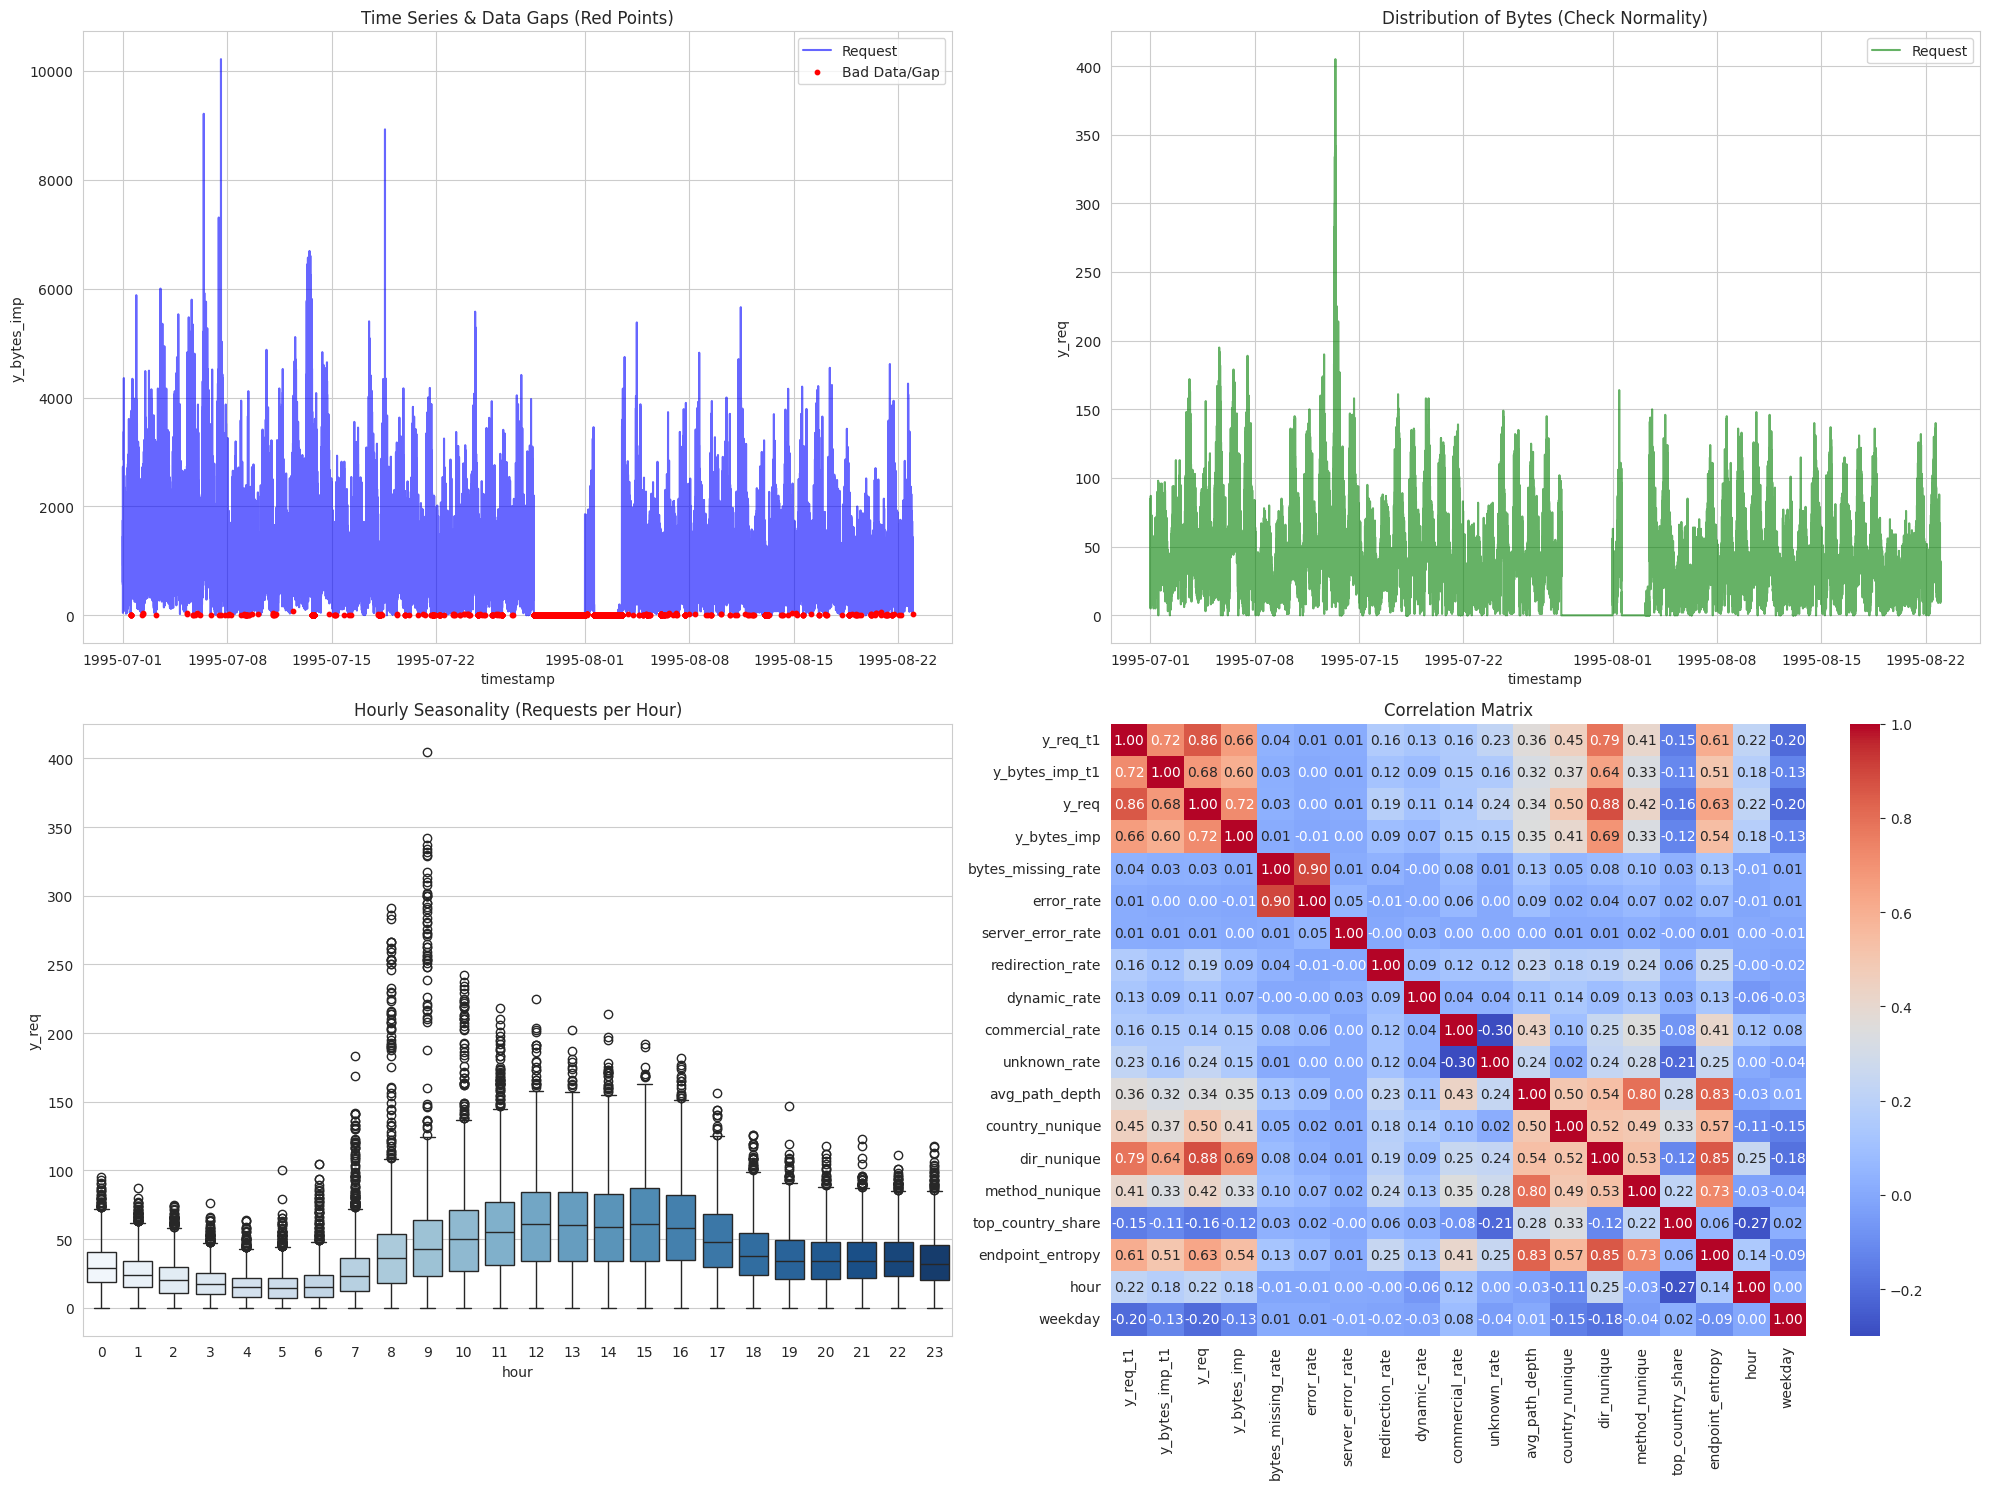

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np


def plot_eda(df):
    sns.set_style("whitegrid")
    fig = plt.figure(figsize=(20, 15))
    
    # 1. TIME SERIES & GAPS 
    ax1 = fig.add_subplot(2, 2, 1)
    sns.lineplot(data=df, x='timestamp', y='y_bytes_imp', ax=ax1, color='blue', label='Request', alpha=0.6)
    
    # Tô màu vùng bị Gap hoặc Missing rate cao
    bad_data = df[(df['flag_data_gap'] == 1) | (df['bytes_missing_rate'] > 0.2)]
    if not bad_data.empty:
        plt.scatter(bad_data['timestamp'], bad_data['y_req'], color='red', s=10, label='Bad Data/Gap', zorder=5)
    
    ax1.set_title("Time Series & Data Gaps (Red Points)")
    ax1.legend()

    #  2. DISTRIBUTION (KIỂM TRA LOG) 
    ax2 = fig.add_subplot(2, 2, 2)
    # Vẽ phân phối của Bytes (thường bị lệch nhất)
    # Cộng 1 để tránh log(0)
    sns.lineplot(data=df, x='timestamp', y='y_req', ax=ax2, color='green', label='Request', alpha=0.6)                                                      
    ax2.set_title("Distribution of Bytes (Check Normality)")
    ax2.legend()
    # 3. SEASONALITY (BOXPLOT THEO GIỜ)
    ax3 = fig.add_subplot(2, 2, 3)
    sns.boxplot(data=df, x='hour', y='y_req', ax=ax3, palette="Blues")
    ax3.set_title("Hourly Seasonality (Requests per Hour)")

    #  4. CORRELATION HEATMAP)
    ax4 = fig.add_subplot(2, 2, 4)
    # Chọn vài cột quan trọng để xem tương quan
    cols_to_corr = [ 'y_req_t1', 'y_bytes_imp_t1', 'y_req', 'y_bytes_imp',
       'bytes_missing_rate', 'error_rate',
       'server_error_rate', 'redirection_rate', 'dynamic_rate',
       'commercial_rate', 'unknown_rate', 'avg_path_depth', 'country_nunique',
       'dir_nunique', 'method_nunique', 'top_country_share',
       'endpoint_entropy', 'hour', 'weekday', ]
    corr = df[cols_to_corr].corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", ax=ax4)
    ax4.set_title("Correlation Matrix")

    plt.tight_layout()
    plt.show()

# Gọi hàm
# plot_eda(df)
plot_eda(df_1m_preprocessed)

DATA PREPROCESSING FOR MACHINELEARNING

In [30]:
import numpy as np
import pandas as pd

def ml_data(df, freq: str):
    df = df.copy()
    #req/bytes
    df["avg_payload"] = df["y_bytes_imp"] / (df["y_req"] + 1e-6)

    # lag/rolling
    cols = [
        "y_req", "y_bytes_imp", "bytes_missing_rate",
        "error_rate", "top_country_share", "endpoint_entropy"
    ]

    mask_gap = df["flag_data_gap"] == 1
    df.loc[mask_gap, cols] = np.nan

    cfg = {
        "1m":  {"lags": (1,2,3,5,15), "windows": (5,15,30)},
        "5m":  {"lags": (1,2,3,6),     "windows": (6,12,24)},
        "15m": {"lags": (1,2,3),       "windows": (3,6,12)}
    }

    lags = cfg[freq]["lags"]
    windows = cfg[freq]["windows"]

    new_cols = {}  # gom tất cả cột mới vào đây (KHÔNG đổi logic)

    # lags
    for c in cols:
        if c not in df.columns:
            continue
        for l in lags:
            new_cols[f"{c}_lag{l}"] = df[c].shift(l)

    # rolling mean/std/
    for c in cols:
        if c not in df.columns:
            continue
        s = df[c].shift(1)
        for w in windows:
            r_mean = s.rolling(w, min_periods=1).mean()
            r_std  = s.rolling(w, min_periods=2).std()

            new_cols[f"{c}_rmean{w}"] = r_mean
            new_cols[f"{c}_rstd{w}"]  = r_std


    # diff (vel/acc)
    for c in cols:
        if c not in df.columns:
            continue
        s_prev = df[c].shift(1)
        vel = s_prev.diff(1)
        new_cols[f"{c}_vel"] = vel
        new_cols[f"{c}_acc"] = vel.diff(1)

    # concat 1 lần -> hết fragmented warning, logic giữ nguyên
    df = pd.concat([df, pd.DataFrame(new_cols, index=df.index)], axis=1)

    # drop, clean 
    df = df[df["flag_data_gap"] == 0].copy()
    df = df.drop(columns=["bytes_missing_rate"])  
    df = df.dropna()
    return df


In [31]:
df_1m_ml=ml_data(df_1m_preprocessed,"1m")
df_5m_ml=ml_data(df_5m_preprocessed,"5m")
df_15m_ml=ml_data(df_15m_preprocessed,"15m")

In [32]:
display(df_1m_ml.head(2))
display(df_5m_ml.head(2))
display(df_15m_ml.head(2))

,timestamp,y_req_t1,y_bytes_imp_t1,y_req,y_bytes_imp,bytes_all_missing,error_rate,server_error_rate,redirection_rate,dynamic_rate,...,y_bytes_imp_vel,y_bytes_imp_acc,bytes_missing_rate_vel,bytes_missing_rate_acc,error_rate_vel,error_rate_acc,top_country_share_vel,top_country_share_acc,endpoint_entropy_vel,endpoint_entropy_acc
15,1995-07-01 00:15:00,82.0,1172.487,5.0,44.218,0,0.0,0.0,0.000000,0.000000,...,-2177.839,-4093.812,0.1,0.117857,0.1,0.1,0.077273,0.143831,0.234133,-0.046530
16,1995-07-01 00:16:00,52.0,1602.189,82.0,1172.487,0,0.0,0.0,0.158537,0.012195,...,-507.364,1670.475,-0.1,-0.200000,-0.1,-0.2,0.100000,0.022727,-1.662256,-1.896388


,timestamp,y_req_t1,y_bytes_imp_t1,y_req,y_bytes_imp,bytes_all_missing,error_rate,server_error_rate,redirection_rate,dynamic_rate,...,y_bytes_imp_vel,y_bytes_imp_acc,bytes_missing_rate_vel,bytes_missing_rate_acc,error_rate_vel,error_rate_acc,top_country_share_vel,top_country_share_acc,endpoint_entropy_vel,endpoint_entropy_acc
6,1995-07-01 00:30:00,361.0,7024.223,326.0,9250.029,0,0.00000,0.0,0.085890,0.01227,...,-1038.458,-3741.095,0.005358,0.023911,0.002907,0.017091,-0.002050,0.019382,0.028463,0.477384
7,1995-07-01 00:35:00,319.0,6146.572,361.0,7024.223,0,0.00554,0.0,0.110803,0.00277,...,3026.102,4064.560,-0.011628,-0.016986,-0.002907,-0.005814,0.019849,0.021900,-0.323350,-0.351813


,timestamp,y_req_t1,y_bytes_imp_t1,y_req,y_bytes_imp,bytes_all_missing,error_rate,server_error_rate,redirection_rate,dynamic_rate,...,y_bytes_imp_vel,y_bytes_imp_acc,bytes_missing_rate_vel,bytes_missing_rate_acc,error_rate_vel,error_rate_acc,top_country_share_vel,top_country_share_acc,endpoint_entropy_vel,endpoint_entropy_acc
3,1995-07-01 00:45:00,750.0,17178.646,804.0,24088.038,0,0.012438,0.0,0.077114,0.012438,...,4374.764,2759.268,-0.006798,-0.002036,-0.001315,-0.000433,0.032706,0.039408,-0.353183,-0.567662
4,1995-07-01 01:00:00,679.0,18621.759,750.0,17178.646,0,0.002667,0.0,0.124000,0.020000,...,1667.214,-2707.550,0.006723,0.013522,0.008462,0.009777,0.004031,-0.028676,0.258683,0.611866


In [33]:
df_1m_ml.to_parquet("../../DATAFLOW_2026_UET.EPOCH_0_AUTOSCALING_ANALYSIS/data/model_ml/train_1m.parquet")
df_5m_ml.to_parquet("../../DATAFLOW_2026_UET.EPOCH_0_AUTOSCALING_ANALYSIS/data/model_ml/train_5m.parquet")
df_15m_ml.to_parquet("../../DATAFLOW_2026_UET.EPOCH_0_AUTOSCALING_ANALYSIS/data/model_ml/train_15m.parquet")

DATA PREPROCESSING FOR DEEPLEARNING

In [34]:
def dl_data(df):
    df=df.copy()

    df["avg_payload"]=df["y_bytes_imp"]/(df["y_req"]+1e-6)
    return df 
display(dl_data(df_1m_preprocessed))
dl_data(df_1m_preprocessed).to_parquet("../../DATAFLOW_2026_UET.EPOCH_0_AUTOSCALING_ANALYSIS/data/model_dl/train_1m.parquet")
dl_data(df_5m_preprocessed).to_parquet("../../DATAFLOW_2026_UET.EPOCH_0_AUTOSCALING_ANALYSIS/data/model_dl/train_5m.parquet")
dl_data(df_15m_preprocessed).to_parquet("../../DATAFLOW_2026_UET.EPOCH_0_AUTOSCALING_ANALYSIS/data/model_dl/train_15m.parquet")



,timestamp,y_req_t1,y_bytes_imp_t1,y_req,y_bytes_imp,bytes_missing_rate,bytes_all_missing,error_rate,server_error_rate,redirection_rate,...,endpoint_entropy,hour,weekday,is_weekend,sin_hour,cos_hour,sin_weekday,cos_weekday,flag_data_gap,avg_payload
0,1995-07-01 00:00:00,61.0,910.128,42,608.453,0.000000,0,0.000000,0.0,0.071429,...,2.884403,0,5,1,0.000000,1.000000,-0.974928,-0.222521,0,14.486976
1,1995-07-01 00:01:00,57.0,628.556,61,910.128,0.016393,0,0.016393,0.0,0.049180,...,3.411756,0,5,1,0.000000,1.000000,-0.974928,-0.222521,0,14.920131
2,1995-07-01 00:02:00,71.0,1747.389,57,628.556,0.035088,0,0.000000,0.0,0.192982,...,3.715645,0,5,1,0.000000,1.000000,-0.974928,-0.222521,0,11.027298
3,1995-07-01 00:03:00,70.0,1383.149,71,1747.389,0.014085,0,0.000000,0.0,0.169014,...,3.601396,0,5,1,0.000000,1.000000,-0.974928,-0.222521,0,24.611112
4,1995-07-01 00:04:00,54.0,933.859,70,1383.149,0.000000,0,0.000000,0.0,0.057143,...,3.079143,0,5,1,0.000000,1.000000,-0.974928,-0.222521,0,19.759271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76314,1995-08-22 23:54:00,13.0,319.726,39,259.912,0.000000,0,0.000000,0.0,0.025641,...,3.098147,23,1,0,-0.258819,0.965926,0.781831,0.623490,0,6.664410
76315,1995-08-22 23:55:00,21.0,436.101,13,319.726,0.000000,0,0.000000,0.0,0.000000,...,1.546594,23,1,0,-0.258819,0.965926,0.781831,0.623490,0,24.594306
76316,1995-08-22 23:56:00,29.0,334.910,21,436.101,0.000000,0,0.000000,0.0,0.000000,...,2.944395,23,1,0,-0.258819,0.965926,0.781831,0.623490,0,20.766713
76317,1995-08-22 23:57:00,29.0,283.098,29,334.910,0.000000,0,0.000000,0.0,0.137931,...,3.147304,23,1,0,-0.258819,0.965926,0.781831,0.623490,0,11.548620
